<a href="https://colab.research.google.com/github/dewipuspita0904/Proyek-Klasifikasi-Gambar/blob/main/Proyek_Klasifikasi_Gambar_Alas_Kaki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Gambar Buah**

Sumber Dataset

https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification?resource=download

# Import Libraries

In [10]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Loading

In [12]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dewipuspita0904","key":"a7a9937d1c9702500fad7fecd92ea12d"}'}

In [14]:
# Set up untuk kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# hapus folder sebelumnya jika ada
!rm -rf ~/.kaggle/shoe-vs-sandal-vs-boot-dataset-15k-images

# Download Dataset
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

# lakuin unzip file
!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d image_dataset

# verifikasi
!ls image_dataset

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
shoe-vs-sandal-vs-boot-dataset-15k-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace image_dataset/Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
'Shoe vs Sandal vs Boot Dataset'


In [26]:
# menentukan direktori dasar tempat dataset disimpan
base_main = 'image_dataset/Shoe vs Sandal vs Boot Dataset/'
image_size = 60
color_mode = "rgb"
class_mode = 'categorical'

# Plot Gambar Sampel Untuk Semua Kelas

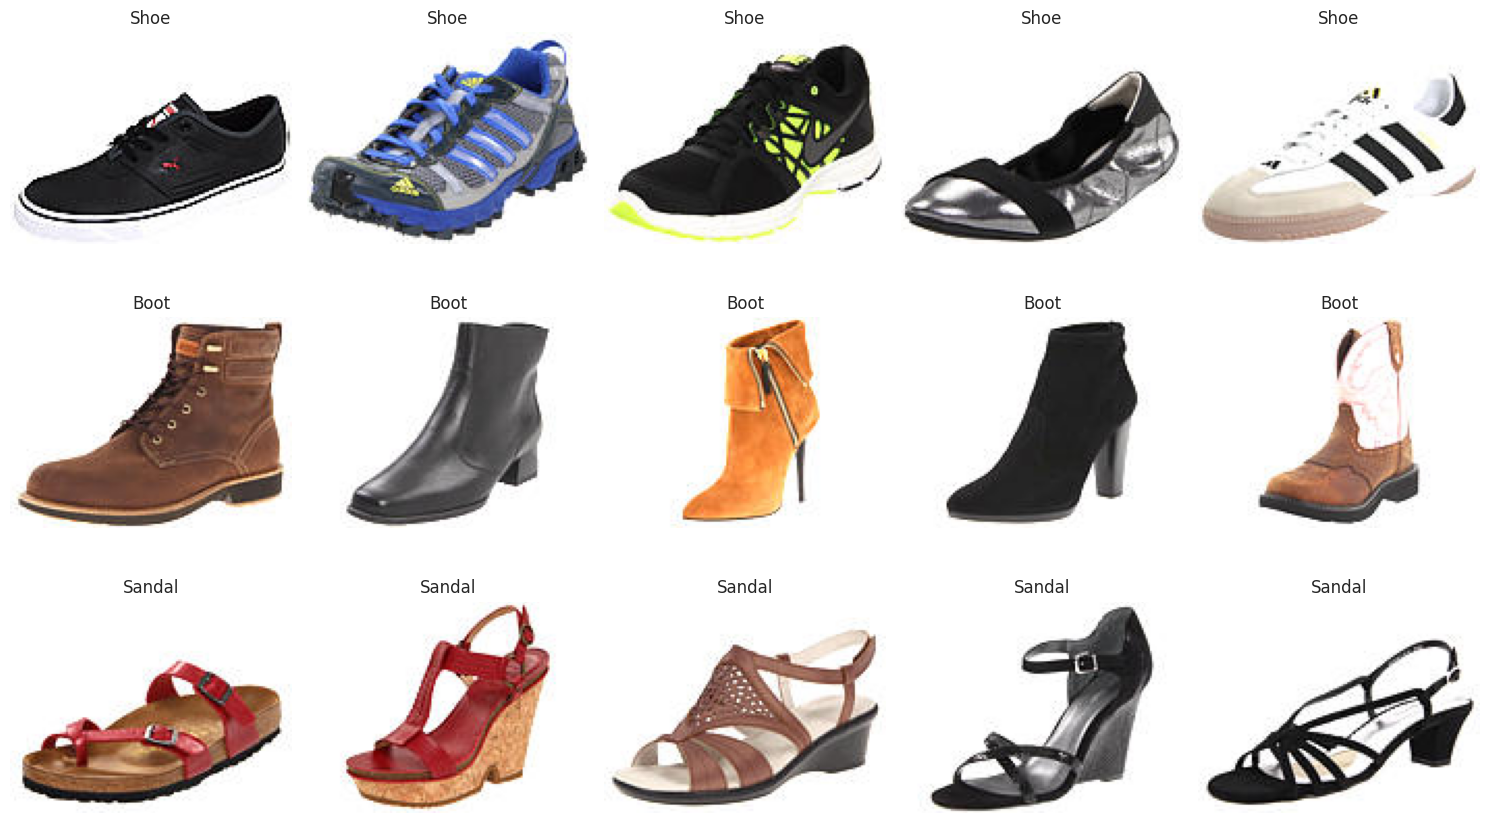

In [27]:
# buat kamus penyimpan daftar gambar untuk tiap kelas
wear_image = {}

# ambil daftar file dari tiap kelas
for class_name in os.listdir(base_main):
  class_dir = os.path.join(base_main, class_name)
  if os.path.isdir(class_dir):
    wear_image[class_name] = os.listdir(class_dir)

# tampilkan 5 gambar acak dari tiap kelas
fig, axs = plt.subplots(len(wear_image.keys()), 5, figsize=(15, len(wear_image)*3))

for i, class_name in enumerate(wear_image):
  image = np.random.choice(wear_image[class_name], 5, replace=False)

  for j, image_name in enumerate(image):
    img_path = os.path.join(base_main, class_name, image_name)
    img = Image.open(img_path)
    axs[i,j].imshow(img)
    axs[i,j].set_title(class_name)
    axs[i,j].axis("off")

plt.tight_layout()
plt.show()

# Plot Distribusi Gambar Seluruh Kelas

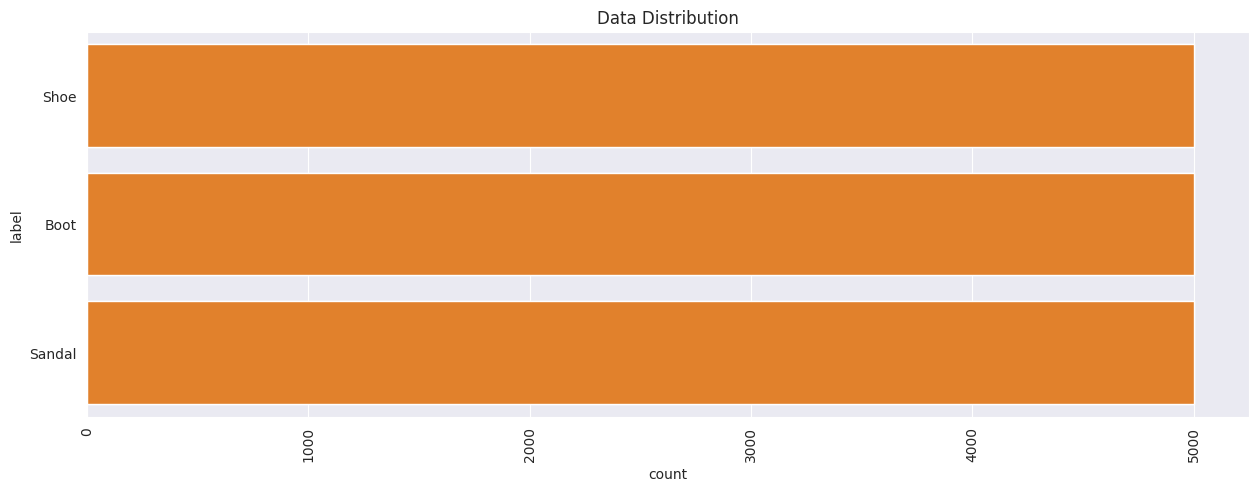

In [28]:
# buat daftar penyimpanan data untuk filename, filepath, dan label
file_name = []
file_path = []
label = []

# ambil daftar nama file, path lengkap, dan label untuk tiap gambar
for class_name in os.listdir(base_main):
  class_dir = os.path.join(base_main, class_name)
  if os.path.isdir(class_dir):
    for image_name in os.listdir(class_dir):
      file_name.append(image_name)
      label.append(class_name)
      file_path.append(os.path.join(class_dir, image_name))

# simpan data di DataFrame
distribution_train = pd.DataFrame({
  "file_name": file_name,
  "file_path": file_path,
  "label": label
})

# plot distribusi gambar berdasarkan kelas
Label = distribution_train['label']
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')
sns.countplot(Label)
plt.title('Data Distribution')
plt.xticks(rotation=90)
plot_data = sns.countplot(Label)
plt.show()


# Data Augmentation

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

#  Data Splitting - 80:10:10

In [30]:
source = base_main
destination = 'dataset_image'

In [31]:
path_f = []
label_f = []

for label in os.listdir(source):
  data_path = os.path.join(source, label)
  for img_f in os.listdir(data_path):
    path_f.append(os.path.join(data_path, img_f))
    label_f.append(label)

df = pd.DataFrame({'path': path_f, 'label': label_f})

In [32]:
# spliting
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['label'])

df_train['set'] = 'train'
df_test['set'] = 'test'
df_val['set'] = 'validation'

df_all = pd.concat([df_train, df_test, df_val], axis=0).reset_index(drop=True)

In [33]:
# combine data
for _, row in tq(df_all.iterrows(), total=len(df_all)):
  my_source = os.path.join(destination, row['set'], row['label'])
  os.makedirs(my_source, exist_ok=True)

  my_destination = os.path.join(my_source, os.path.basename(row['path']))
  if not os.path.exists(my_destination):
    shutil.copy(row['path'], my_destination)

print(f"Selesai")

  0%|          | 0/15000 [00:00<?, ?it/s]

Selesai


In [34]:
# bagi jumlah file tiap set

def count_file_dir(path):
  count = 0
  for root, dirs, files in os.walk(path):
    count += len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])
  return count

print("Jumlah file tiap dataset")
print(f"Train: {count_file_dir('dataset_image/train')}")
print(f"Test: {count_file_dir('dataset_image/test')}")
print(f"Validation: {count_file_dir('dataset_image/validation')}")

Jumlah file tiap dataset
Train: 12000
Test: 1500
Validation: 1500


# Model Development

In [35]:
test = 'dataset_image/test'
train = 'dataset_image/train'
valid = 'dataset_image/validation'

img_w = 180
img_h = 180

data_generator = ImageDataGenerator(
    rescale=1.0/255
)

data_train = tf.keras.utils.image_dataset_from_directory(
    train,
    image_size=(img_w, img_h),
    color_mode=color_mode,
    batch_size=32,
    shuffle=True,
    validation_split=False
)

data_validation = tf.keras.utils.image_dataset_from_directory(
    valid,
    image_size=(img_w, img_h),
    color_mode=color_mode,
    batch_size=32,
    shuffle=True,
    validation_split=False
)

data_test = tf.keras.utils.image_dataset_from_directory(
    test,
    image_size=(img_w, img_h),
    color_mode=color_mode,
    batch_size=32,
    shuffle=True,
    validation_split=False
)

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


# CNN Model with Keras Sequential API

In [41]:
cnn_model = Sequential([
    # first convolutional layer
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(img_w, img_h, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # second convolutional layer
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # third convolutional layer
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
class stop(tf.keras.callbacks.Callback):
  def __init__(self, target = 0.99):
     super(stop, self).__init__()
     self.target = target

  def on_epoch_end(self, epoch, logs=None):
    acc = logs.get("accuracy")
    val_acc = logs.get("val_accuracy")

    if acc is not None and val_acc is not None:
      if acc >= self.target and val_acc >= self.target:
        print(f"Proses dihentikan di epoch ke- {epoch+1}")
        self.model.stop_training = True

In [43]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,157 (12.59 MB)

 Trainable params: 3,301,157 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
stop_call = stop(target=0.98)

history = cnn_model.fit(
    data_train,
    validation_data=data_validation,
    epochs=10,
    callbacks=[stop_call]
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.6414 - loss: 34.8750 - val_accuracy: 0.9027 - val_loss: 0.2920
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.8856 - loss: 0.3161 - val_accuracy: 0.9307 - val_loss: 0.2197
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.9142 - loss: 0.2441 - val_accuracy: 0.9293 - val_loss: 0.2147
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.9248 - loss: 0.2082 - val_accuracy: 0.9407 - val_loss: 0.1849
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - accuracy: 0.9369 - loss: 0.1828 - val_accuracy: 0.9527 - val_loss: 0.1449
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.9487 - loss: 0.1421 - val_accuracy: 0.9500 - val_loss: 0.1693
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.9509 - loss: 0.1364 - val_accuracy: 0.9587 - val_loss: 0.1496
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.9617 - loss: 0.1103 - val_acc

In [52]:
test_loss, test_acc = cnn_model.evaluate(data_test)
print(f"Data test accuracy: {test_acc:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 379ms/step - accuracy: 0.9709 - loss: 0.1109
Data test accuracy: 0.96


# Visualisasi

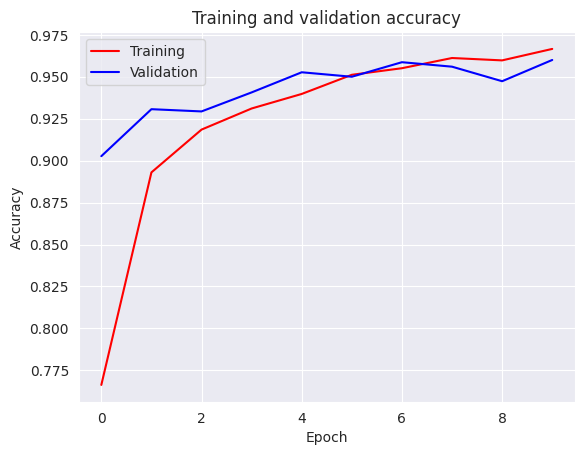

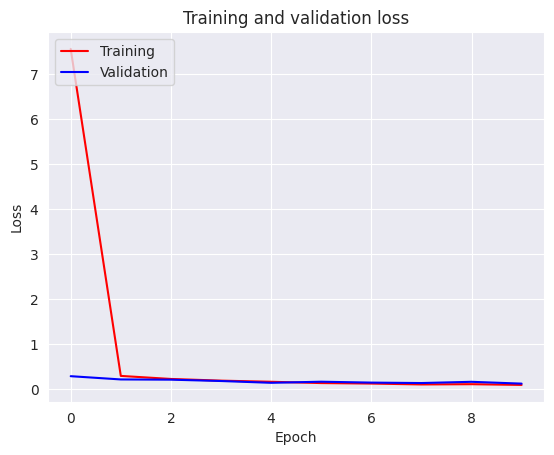

In [54]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

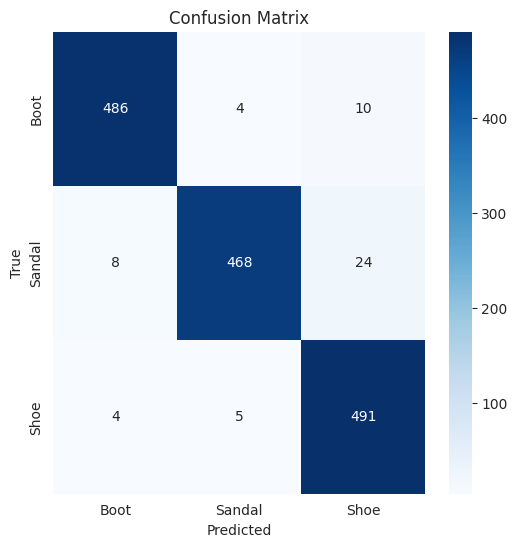

              precision    recall  f1-score   support

        Boot       0.98      0.97      0.97       500
      Sandal       0.98      0.94      0.96       500
        Shoe       0.94      0.98      0.96       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for image_batch, label_batch in data_test:
  y_true.extend(label_batch.numpy())
  predictions = cnn_model.predict(image_batch, verbose=0)
  y_pred.extend(np.argmax(predictions, axis=1))

confusion_matrix = confusion_matrix(y_true, y_pred)
class_names = data_train.class_names

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

Saving image_test.jpeg to image_test (4).jpeg


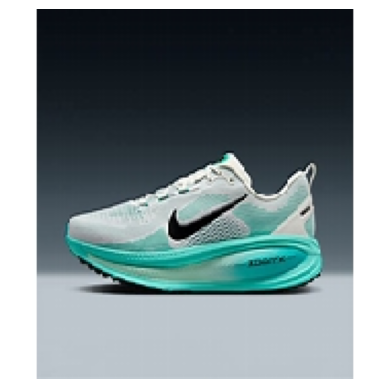

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
image_test (4).jpeg
Shoe
0.36579695
Boot: 0.21
Sandal: 0.36
Shoe: 0.37


In [77]:
upload = files.upload()

for fn in upload.keys():
  path = fn
  img = image.load_img(path, target_size=(img_w, img_h))
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x /= 225

  images = np.vstack([x])
  predictions = cnn_model.predict(images, batch_size=10)
  prediction_class = np.argmax(predictions[0])

  class_names = [str(i) for i in class_names]

  print(fn)
  print(class_names[prediction_class])
  print(predictions[0][prediction_class])

  for i, class_name in enumerate(class_names):
    print(f"{class_name}: {predictions[0][i]:.2f}")

# Menyimpan Model

In [67]:
# SavedModel
saved_model = 'saved_model/'
tf.saved_model.save(cnn_model, saved_model)

In [68]:
# konversi ke TensorFlow.js
!pip install tensorflowjs
import tensorflowjs as tfjs

In [69]:
# save model TF.js
tfjs_dir = "tfjs_model"
tfjs.converters.save_keras_model(cnn_model, tfjs_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [70]:
# tflite
model_dir = "tflite"
os.makedirs(model_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
tflite_model = converter.convert()

tflite_model_file = os.path.join(model_dir, "model.tflite")
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

label = data_train.class_names
label_path = os.path.join(model_dir, "labels.txt")

with open(label_path, "w") as f:
  f.write("\n".join(label))

with open(label_path, "r") as f:
  print(f.read())

Boot
Sandal
Shoe


In [78]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confe